### 👨‍🏭 Albertus Septian Angkuw
### Hierarchical Clustering Analysis

In [1]:
currentPath = "/Users/albertusangkuw/Documents/ClusteringForDekomposisi"

### Ekstraksi Dependency Module

In [2]:
import os
import importlib.util
import inspect

In [3]:
def walkTroughFolder(folderSC,filterExt='.py'):
    listFile = []
    for file in os.listdir(f'{currentPath}/{folderSC}'):
        if os.path.isdir(f'{currentPath}/{folderSC}/{file}'):
            listFile += walkTroughFolder(f'{folderSC}/{file}')
        elif file.endswith(filterExt):
            #print(os.path.join(f'/{folderSC}', file))
            listFile.append(os.path.join(f'/{folderSC}', file))
    return listFile

In [4]:
def pathToModule(files,removeFile=True):
    coreModule = []
    for x in files:
        if x.count('.') > 1:
            # print("Skipped, Path Contain '.' : " , x)
            continue
        tmpArr = x[:-3].split("/")[2:]
        if removeFile:
            tmpArr = tmpArr[:-1]
        tmp = '.'.join(tmpArr)
        if tmp not in coreModule:
            coreModule.append(tmp)
    return coreModule

In [5]:
def scanModuleWithInspect(modulePath):
    # modulePath = "addons.account.models"
    runcommand = importlib.import_module(modulePath)
    listClass = {}
    for name, obj in inspect.getmembers(runcommand):
        if inspect.ismodule(obj) == False:
            continue
        # print("Module:" ,  name)
        member = inspect.getmembers(obj)
        tmpClass = {}
        
        for item in member:
            # item => [ 0 => 'name',  1 => 'value member'   ]
            if inspect.isclass(item[1]) == False:
                continue
            if hasattr(item[1], '__class__') and str(item[1].__class__) != "<class 'odoo.models.MetaModel'>":
                # print(f'Class "{item[0]}" Skipped because not MetaModel')
                continue
            # print(item[1].__dict__)
            if hasattr(item[1], '_name'):
                tmpClass[item[0]] = { 'name' : item[1]._name}
            if hasattr(item[1], '_inherit'):
                # Case Class Model tidak punya nama
                if tmpClass[item[0]]['name'] in item[1]._inherit  :
                    tmpClass[item[0]]['name'] = item[1].__module__
                tmpClass[item[0]]['inherit'] = item[1]._inherit                       
            if hasattr(item[1], '_inherits'):
                tmpClass[item[0]]['inherits'] = item[1]._inherits
            classMembers = inspect.getmembers(item[1])
            
            tmpClass[item[0]]['attribute_rel'] = {}
            for attrClass in classMembers:
                if hasattr(attrClass[1], 'comodel_name'):
                    if attrClass[1].comodel_name != None:
                        tmpClass[item[0]]['attribute_rel'][attrClass[0]] = attrClass[1].comodel_name 
        
        if len(tmpClass) > 0:
            # print(f'Total Model Class: {len(tmpClass)} ')
            # print("--------------------")
            listClass[name] = tmpClass
            # print(tmpClass)
        # print("---------------")
    return listClass
        

In [6]:
listModule = [ f'odoo.{s}' for s in pathToModule(walkTroughFolder("odoo/addons")) ] 
listModuleName = {}
moduleNameMapping = {}
def searchDependency(module):
    res = scanModuleWithInspect(module)
    for k , m in res.items():
        if len(m) == 0:
            continue
        for _ , c in m.items():
            if c['name'] not in listModuleName:
                moduleNameMapping[c['name']] = f'{module}.{k}'
                listModuleName[c['name']] = []
            if 'inherit' in c and len(c['inherit']) > 0:
                if isinstance(c['inherit'],list):
                    listModuleName[c['name']] += c['inherit']
                elif isinstance(c['inherit'],str):
                    listModuleName[c['name']].append(c['inherit'])
                else:
                    print("Warn: Data Type Not Found: " , c['name'] )
            if 'inherits' in c and len(c['inherits']) > 0:
                listModuleName[c['name']] += list(c['inherits'].keys())
            if 'attribute_rel' in c and  len(c['attribute_rel'])  > 0:            
                listModuleName[c['name']] += list(c['attribute_rel'].values())

for m in listModule:
    try:
        searchDependency(m)
    except Exception as e:
        print("Exception :", e  , m)


Attachment indexation of PDF documents is unavailable because the 'pdfminer' Python library cannot be found on the system. You may install it from https://pypi.org/project/pdfminer.six/ (e.g. `pip3 install pdfminer.six`)
Could not import library dbus
Exception in thread Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/albertusangkuw/opt/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
Thread-8:
Traceback (most recent call last):
  File "/Users/albertusangkuw/opt/anaconda3/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/Users/albertusangkuw/Documents/ClusteringForDekomposisi/odoo/addons/hw_drivers/connection_manager.py", line 25, in run
    self.run()
  File "/Users/albertusangkuw/Documents/ClusteringForDekomposisi/odoo/addons/hw_drivers/main.py", line 83, in run
    if not helpers.get_odoo_server_url() and not helpers.access_point():
  File "/Users/albertusangkuw/Documents/ClusteringForDekomposisi/odo

In [7]:
# Ilustrasi isi scan module melalui Inspect
print("Pos Category :"  , listModuleName['pos.category'])
print("Product Tag : " , listModuleName['product.tag'])

Pos Category : ['pos.category', 'res.users', 'pos.category', 'res.users']
Product Tag :  ['res.users', 'product.product', 'product.product', 'product.template', 'res.users']


In [8]:
# Ilustrasi hasil peta sumber module 
print("Pos Category :"  , moduleNameMapping['pos.category'])
print("Product Tag : " , moduleNameMapping['product.tag'])

Pos Category : odoo.addons.point_of_sale.models.pos_category
Product Tag :  odoo.addons.product.models.product_tag


### Pengabungan Hasil Ekstraksi

In [9]:
addonsJSON = f'{currentPath}/odooAddons.json'

#### Pembacaan Hasil Call Graph JSON

In [10]:
import json
def loadJSON(path):
   return json.load(open(path))

In [11]:
def getListRootPackage(path):
    listRootPackage = []
    for file in os.listdir(f'{path}'):
        if os.path.isdir(f'{path}/{file}'):
            listRootPackage.append(file)
        elif file.endswith('.py'):
            listRootPackage.append('.'.join(file.split(".")[:-1]))
    return listRootPackage

In [12]:
def addPrefixFolder(cg,root,listPackage):
    def checkParent(key):
        parentkey = key.split('.')[0]
        if parentkey in listPackage:
            key = f'{root}.{key}'
        return key
    newCG = {}
    for key, relation in cg.items():
        key = checkParent(key)
        if key not in newCG:
            newCG[key] = []
        for i in relation:
            newRelKey = checkParent(i)
            newCG[key].append(newRelKey)
    return newCG

In [13]:
cgAddonsSource =loadJSON(addonsJSON)
listPackageAddons = getListRootPackage(f'{currentPath}/odoo/addons')
print(list(cgAddonsSource.values())[:5])
print(len(cgAddonsSource))
callGraphRaw = addPrefixFolder(cgAddonsSource,"addons",listPackageAddons)
len(callGraphRaw)

[[], ['odoo.api.Environment'], [], [], []]
27521


27521

In [14]:
print("Fungsi di model Product Tag yang terdeksi melalui PyCG")
print(callGraphRaw['addons.product.models.product_tag.ProductTag._get_default_color'])
print(callGraphRaw['addons.product.models.product_tag.ProductTag._compute_product_ids'])

Fungsi di model Product Tag yang terdeksi melalui PyCG
['random.randint']
[]


In [15]:
def filterCGNode(cgSource):
    def checkIsBase(key):
        parentKey = key.split('.')
        if parentKey[0] == 'odoo' and  parentKey[1] == 'addons':
            # Ganti addons diluar base
            if len(parentKey) >= 3 and parentKey[2] != 'base':
                key = '.'.join(key.split('.')[1:])
        return key
    
    callGraphFiltered = {}
    listRootFolder = [ 'odoo', 'addons']
    edgeGraph = []
    outsideCall = set()
    for key, value in cgSource.items():
        rootSource = key.split('.')[0]
        if rootSource not in listRootFolder:
            outsideCall.add(rootSource)
            continue
        childFilter = {}
        for v in value:
            childSource = v.split('.')[0]
            if childSource not in listRootFolder:
                outsideCall.add(childSource)
                continue
            v = checkIsBase(v)
            childFilter[v] = 1
        if len(childFilter) == 0:
            edgeGraph.append(key)
            continue
        key = checkIsBase(key)
        for c in childFilter:
            if c not in callGraphFiltered:
                callGraphFiltered[c] = {}
        callGraphFiltered[key] = childFilter
    print(f'Total Node Awal: {len(cgSource)} ')    
    print(f'Total Node: {len(callGraphFiltered)} ')
    print(f'Total Leaf Node: {len(edgeGraph)} <{edgeGraph[:3]}>')
    print(f'Total Call Diluar package Odoo : {len(outsideCall)} <{list(outsideCall)[:3]}>')
    return callGraphFiltered

In [16]:
callGraphFiltered = filterCGNode(callGraphRaw)

Total Node Awal: 27521 
Total Node: 15953 
Total Leaf Node: 14287 <['addons.base', 'odoo.api.Environment', 'addons.base.wizard']>
Total Call Diluar package Odoo : 113 <['ctypes', 'optparse', 'logging']>


#### Depedency Module (Inspect)

In [17]:
def updateCGwInspect(callGraphFiltered,listModuleName,moduleNameMapping):
    def levelingPathAddons(path):
        pathSplit = path.split(".")
        if pathSplit[0] == "odoo":
            return ".".join(pathSplit[1:])
        return path   
    for r in listModuleName:
        if r not in moduleNameMapping:
            print("Path not Found " , r)
            continue
        if moduleNameMapping[r] not in callGraphFiltered:
            moduleName = levelingPathAddons(moduleNameMapping[r])
            callGraphFiltered[moduleName] = {}
        for c in listModuleName[r]:
            moduleName = levelingPathAddons(moduleNameMapping[r])
            if c not in moduleNameMapping:
                print("Path Call not Found " , c)
                continue
            tmpC = levelingPathAddons(moduleNameMapping[c])
            if tmpC not in callGraphFiltered[moduleName]:
                # print("new key: " , moduleNameMapping[r] , tmpC)
                callGraphFiltered[moduleName][tmpC] = 0
            callGraphFiltered[moduleName][tmpC] += 1
    return callGraphFiltered

In [18]:
callGraphFiltered = updateCGwInspect(callGraphFiltered,listModuleName,moduleNameMapping)

Path Call not Found  export.one2many


### Optimisasi Graph 

#### Tracing Call

In [19]:
class NodeCG:
    root = ""
    def __init__(self,name,parent):
        self.name = name
        self.parent = parent
        self.outsideCall = {}
        self.insideCall = {}
        self.relation = {}    
    
    def getRelation(self,name=""):
        newName, childName = self.shiftTargetName(name)
        if newName in self.relation:
            relCC = self.relation[newName].getRelation(childName)
            return {self.name : relCC}
        listRelation = list(self.relation.keys())
        return { self.name : { 'outsideCall' : self.outsideCall , 
                'relation' : listRelation, 'insideCall': self.insideCall}}
        
    
    def setRelation(self,name,targetCall):
        self.isValidName(name)
        newName, childName = self.shiftTargetName(name)
        
        currentAsParent = self.parent.copy()
        if self.name == self.root:
            currentAsParent = []
        else:
            currentAsParent.append(self.name)    
            
        if newName not in self.relation:
            #Tambah node dan beri tahu dia memberi tahu node parentnya
            self.relation[newName] = NodeCG(newName,currentAsParent)    
        
        #Kondisi bila bukan paling akhir masih ada child
        currParentStr = '.'.join(currentAsParent)
        for t in targetCall:
            cutStr = t.split(".")
            targetParent = ".".join(cutStr[0:len(self.parent)+1]) 
            if targetParent == currParentStr:
                # Menambahkan kepada insidecall bila sesuai dengan parent sekarang 
                # 'addons.product.models.A' => 'addons.product.models.B'
                if t not in self.insideCall:
                    self.insideCall[t] = 0
                self.insideCall[t] += targetCall[t]
            elif self.name != self.root :
                # Menambahkan kepada outsidecall bila tidak sesuai dengan parent sekarang 
                # 'addons.product.models' => 'addons.note.models
                if t not in self.outsideCall:
                    self.outsideCall[t] = 0
                self.outsideCall[t] += targetCall[t]
        
        #Kondisi bila sudah paling akhir    
        if childName == "" and newName == name:
            self.relation[newName].outsideCall = targetCall
            return True   
        
        return self.relation[newName].setRelation(childName,targetCall)
    
    def shiftTargetName(self,strName):
        # 'adddons.product.models' => 'addons' , 'product.models'
        cutStr = strName.split(".")
        if len(cutStr) > 1:
            return cutStr[0] , ".".join(cutStr[1:])
        return cutStr[0] , ""
    
    def isValidName(self,name):
        if not isinstance(name,str):
            raise Exception("Nama Node harus str")
        if name.strip() == "":
            raise Exception("Nama Kosong")
    
    def countCall(self,nodeName):
        r , cCName = self.shiftTargetName(nodeName)
        if  r in self.relation:
            return self.relation[r].countCall(cCName)            
        elif  cCName == "" and r == "":
            oc = self.outsideCall.copy()
            currentAsParent = self.parent.copy()
            currentAsParent.append(self.name)   
            currParentStr = '.'.join(currentAsParent)
            oc[currParentStr] = self.insideCall
            return oc
        else:
            return {} 
    

In [20]:
odooTree = NodeCG("odoo",[])
odooTree.root = "odoo"
blackListNodeName = ['tests', 'testing','test', 'l10n' ]
def checkNameKey(k):
    def checkIfNameContainString(v,t):
        separtorName = ["_" , "."  , "-"]
        if v == t:
            return True
        idx = v.find(t)
        if idx ==  -1:
            return False
        #Bila muncul di awal
        if idx == 0 and idx+len(t) < len(v) and v[idx+len(t)] in separtorName:
            return True
        #Bila muncul di tengah
        elif idx+len(t) < len(v) and v[idx+len(t)] in separtorName and v[idx-1] in separtorName:
            return True
        #Bila muncul di akhir
        elif idx+len(t) == len(v) and v[idx-1] in separtorName :
            return True
        return False
    for n in blackListNodeName:
        if checkIfNameContainString(k,n):
            # print("Skipped : " , k)
            return False
    cutStr = k.split(".")
    if cutStr[0] != "addons":
        return False
    return True

for k,v  in callGraphFiltered.items():
    if not checkNameKey(k):
        continue
    tmpV = {}
    for i in v:
        if not checkNameKey(i):
            continue
        tmpV[i] = v[i]
    if len(tmpV) == 0:
        continue
    odooTree.setRelation(k ,tmpV)
    

#### Pemberian Weight pada Graph

In [21]:
def initKeyCG():
    listModuleF = [ f'{s}' for s in pathToModule(walkTroughFolder('odoo/addons'),removeFile=False)]
    #Versi Per Addons
    def checkIsBP(m):
        blackLS = ['test', 'l10n', '__init__']
        for i in blackLS:
            if i in m:
                return True
        return False
    
    callGraphWeight = {}
    for m in listModuleF:
        arrM = m.split(".")
        if checkIsBP(m):
            continue
        if arrM[0] == "addons" and f'{arrM[0]}.{arrM[1]}' not in callGraphWeight:
            callGraphWeight[f'{arrM[0]}.{arrM[1]}'] = {}
        elif arrM[1] == "base" and m not in callGraphWeight:
            callGraphWeight[m] = {}
    return callGraphWeight

In [22]:
def updateCGWeight(odooTree,callGraphWeightNew):
    newCG = {}
    for curr , _ in callGraphWeightNew.items():
        if curr == "addons.base":
            continue
        res = odooTree.countCall(curr)
        if len(res) < 2:
            # print(f"Module {curr} dilewati karena tidak memiliki relasi")
            continue
        arrC = curr.split(".")
        if curr not in newCG:
            newCG[curr] = {}
        for foundRel,freqRel in res.items():
            ## Update relasi panggilan internal node
            if foundRel == curr:
                total = 0
                for i,cFreq in res[foundRel].items():
                    total += cFreq
                #Ketika tidak ada relasi internal
                if total == 0:
                    continue
                newCG[curr][curr] = total
                continue
            relPath = foundRel.split(".")
            if len(relPath) < 2:
                print("Warn, relasi lebih rendah tidak bisa")
                continue
            newRelPath = f"{relPath[0]}.{relPath[1]}"
            # Hanya Base addons yang semua bagian dapat dipecah
            if relPath[1] == "base":
                newRelPath = foundRel
            if newRelPath not in callGraphWeightNew:
                print("Info, Relasi dari Target dilewati " , newRelPath)
                continue
            if newRelPath not in newCG and newRelPath in callGraphWeightNew:
                newCG[newRelPath] = {}
            if newRelPath not in newCG[curr]:
                newCG[curr][newRelPath] = 0
            newCG[curr][newRelPath] += freqRel   
    return newCG 

In [23]:
def cleanUpCG(cg):
    def cekKey(key):
        arrC = key.split(".")
        if arrC[0] == "addons":
            return True
        else:
            if len(arrC) >= 2 and f'{arrC[0]}.{arrC[1]}' == "odoo.addons":
                return True
            return False

    newCG = {}
    selfCallCG = {}
    for x, connection in cg.items():
        if cekKey(x) == False:
            continue
        if x == 'odoo.addons.__init__':
            continue
        if x not in newCG:
            newCG[x] = {}
        for name, weight in connection.items():
            if cekKey(name) == False:
                continue
            #Self Call
            if x == name:
                selfCallCG[x] = weight
                continue
            #Module Redirect
            if name == 'odoo.addons.__init__':
                continue
            if name not in newCG[x]:
                newCG[x][name] = 0
            newCG[x][name] += weight
    return newCG, selfCallCG

In [24]:
def removeNotConnectedNode(cg ={}):
    knownRelation = set()
    for c in cg:
        for call in cg[c]:
            knownRelation.add(call)
        if len(cg[c]) > 0:
            knownRelation.add(c)
    keyCG = list(cg.keys())
    for k in keyCG:
        if k not in knownRelation:
            del cg[k]
            # print("Deleted Key: " , k)
    return cg

#### Representasi Call Graph menjadi Adjacency Matrix

In [25]:
import numpy as np

In [26]:
def createAdjacentMatrix(graphSource):
    def normalisasiWeight(newAdj):
        import warnings
        warnings.simplefilter("ignore")

        # By column-wise normalization
        newAdj = (newAdj-newAdj.min(axis=0))/(newAdj.max(axis=0)-newAdj.min(axis=0))
        newAdj[np.isnan(newAdj)] = 0

        return newAdj
    listLabel = {}
    counterListLabel = 0
    for label in graphSource.keys():
        listLabel[label] = counterListLabel
        counterListLabel+=1
    adjMatrix = np.zeros(shape=(len(listLabel), len(listLabel)))

    currRow = 0
    tmpNotDetected = 0
    for x, connection in graphSource.items():
        for name, weight in connection.items():
            if name not in listLabel:
                tmpNotDetected += 1
                continue
            adjMatrix[currRow,listLabel[name]] = weight
        currRow+=1 
    if tmpNotDetected > 0:
        print("------------")
        print("Not Detected: " , graphSource , adjMatrix  ,listLabel)
        print("------------")
    return normalisasiWeight(adjMatrix), listLabel

In [27]:
callGraphWeight = initKeyCG()
callGraphWeight = updateCGWeight(odooTree,callGraphWeight)
callGraphWeightKey = list(callGraphWeight.keys())

cgFilterInternal, selfCG = cleanUpCG(callGraphWeight)
callGraphFinal = removeNotConnectedNode(cgFilterInternal)
adjMatrix, dictLabel = createAdjacentMatrix(callGraphFinal)
listLabel = list(dictLabel.keys())
print("Size Label: " ,len(dictLabel))

Info, Relasi dari Target dilewati  addons.__path__
Info, Relasi dari Target dilewati  addons.__path__
Info, Relasi dari Target dilewati  addons.decimal_precision
Size Label:  335


In [28]:
if input("Simpan Adj Matrix ?(Y/N)") == "Y":
    np.savetxt(f'tmp-AdjMatrix.csv', adjMatrix, delimiter=",")

### Hierarchical Clustering

#### Distance Matrix

In [29]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
import numpy as np

In [30]:
def simStr(ci, cj, i, j, callsinCi , callsinCj):
    res = 0
    if callsinCi > 0 and callsinCj > 0:
        res = 0.5 * ( ci[j]/callsinCj +  cj[i]/callsinCi )
    elif callsinCi == 0 and callsinCj > 0:
        res = ci[j]/callsinCj
    elif callsinCi > 0 and callsinCj == 0:
        res = cj[i]/callsinCi
    return res

In [31]:
def simJaccard(row, col):
    row = np.asarray(row,bool)
    col = np.asarray(col,bool)
    
    if row.shape != col.shape:
        raise ValueError("Not same size")

    intersection = np.logical_and(row, col)
    union = np.logical_or(row, col)
    return  (intersection.sum() / float(union.sum()))

In [32]:
def calculateDistanceMatrix(adjMatrix):
    data = np.array(adjMatrix)
    distanceMatrix = [[0.00 for i in range(data.shape[1])] for j in range(data.shape[0])]

    np.fill_diagonal(data,1) 
    for row in range(0,len(data)):
        for col in range(0,row):
            # Semakin jauh mendekati nilai 1, mengambil satu bagian untuk masing masing col
            distanceStructual = round(1- simStr(data[row, :], data[col, :], row, col,sum(data[:, row]), sum(data[:, col])),2)
            distanceJaccard = round(1- simJaccard(data[row, :] , data[col,:]),2)
            distanceMatrix[row][col] = ((distanceStructual + distanceJaccard   ) / 2)
            distanceMatrix[col][row] = distanceMatrix[row][col]
    return distanceMatrix

In [33]:
def visualizeHeatmap(matrix, title):
    fig, ax = plt.subplots()
    im = ax.imshow(matrix)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    ax.set_title(title)
    plt.figure(figsize=(20,6))
    plt.show()

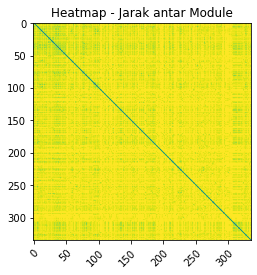

<Figure size 1440x432 with 0 Axes>

In [34]:
distanceMatrix = calculateDistanceMatrix(adjMatrix)
distanceMatrix = np.array(distanceMatrix)
visualizeHeatmap(distanceMatrix,"Heatmap - Jarak antar Module") 

#### Clustering

In [35]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

In [36]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

#Source: https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib
def augmented_dendrogram(*args, **kwargs):

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata

In [109]:
def visualizeDendogram(z,_method):
    # plt.figure(figsize=(4,25), dpi=300)

    # plt.figure(figsize=(10,5))
    sch.dendrogram(z, color_threshold=0 ,labels=listLabel , link_color_func=lambda *args: 'k' , orientation='right')
    # ddata = sch.dendrogram(z,labels=listLabel,distance_sort='descending',leaf_font_size=8.)
    # augmented_dendrogram(z, labels=listLabel)
    plt.title(f'Dendrogram {_method} Linkage')
    plt.xlabel('Module')
    plt.ylabel('Distances')
    # plt.xticks(rotation=90)
    # plt.tick_params(axis='x', which='both', labelsize=0)
    plt.show() 

In [38]:
def calculateCluster(y,_method):
    z  =  linkage(y, method=_method)
    visualizeDendogram(z,_method)
    return z

In [96]:
cDM = squareform(distanceMatrix,checks=True)

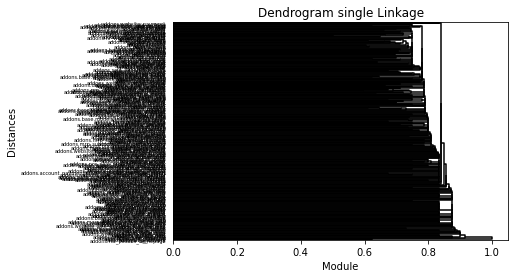

In [110]:
zSingle = calculateCluster(cDM,"single")

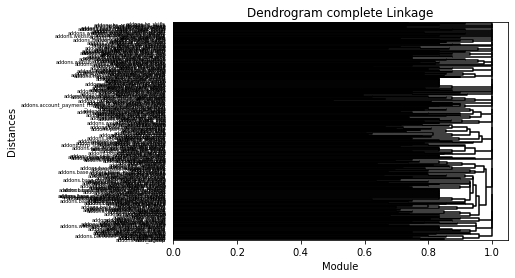

In [111]:
zComplete = calculateCluster(cDM,"complete")

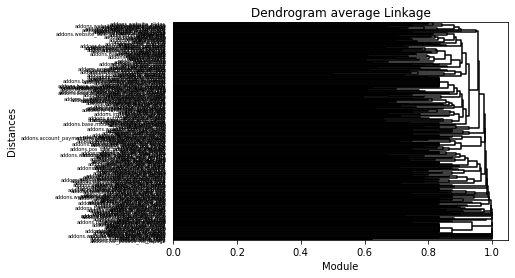

In [112]:
zAverage = calculateCluster(cDM,"average")

### Pemilihan Partisi

In [43]:
from scipy.cluster.hierarchy import cut_tree

In [44]:
def mergeClass(ct):
    refCall = {}
    for i in range(0,len(ct)):
        refCall[listLabel[i]] = ct[i][0]

    mergeCall = {}
    innerCallClass = {}    
    for call, cNum in refCall.items():
        if cNum not in innerCallClass:
            mergeCall[cNum] = {}
            innerCallClass[cNum] = {}
        #Inner Class Shell
        if call not in innerCallClass[cNum]:
            innerCallClass[cNum][call] = {}
        for k, w in callGraphFinal[call].items():
            #Cek apakah panggilan antar cluster
            tmpKey = k
            if refCall[k] != cNum:
                tmpKey = refCall[k]
                #Tambah di Merge untuk outside cluster call
                if refCall[k] not in mergeCall[cNum]:
                    mergeCall[cNum][refCall[k]] = 0
                mergeCall[cNum][refCall[k]] += w

            if tmpKey not in innerCallClass[cNum][call]:
                innerCallClass[cNum][call][tmpKey] = 0
            innerCallClass[cNum][call][tmpKey] += w
        
    return mergeCall, innerCallClass

In [45]:
def cutTreeToCluster(ct):
    c = {}
    for i, x in enumerate(ct):
        if x[0] not in c:
            c[x[0]] = []
        c[x[0]].append(listLabel[i])
    return c        

Measuring Focused on One Functionality Characteristic of a Microservice: 

In [46]:
def CoupP(m, c1,c2):
    def NbCalls(m,c1,c2):
        return m[c2][c1]
    TotalNBCalls = 0
    for x in range(0,len(m)):
        if m[c1][x] > 0:
            TotalNBCalls += m[c1][x]
        if m[c2][x] > 0:
            TotalNBCalls += m[c2][x]
    if TotalNBCalls == 0:
        return 0
    return (NbCalls(m,c1,c2) + NbCalls(m,c2,c1))/TotalNBCalls

In [47]:
def InterCoup(m):
    sumCoup = 0
    NbPossiblePairs = len(m)
    for c1 in range(0,len(m)):
        for c2 in range(0,len(m)):
          tmp = CoupP(m,c1,c2)
          sumCoup += tmp
          
    return sumCoup/NbPossiblePairs

In [48]:
def InterCoh(rm):
    NbDirectConnections = 0
    NbPossibleConnection = 0
    #Menghitung Panggilan Internal
    for _, p in rm.items():
        if len(p) == 0:
            continue
        for m ,  call in p.items():
            #Pertibangkan Call dalam Addons/Modules
            if m in selfCG:
                NbDirectConnections += selfCG[m]
            for c, w in call.items():
                #External Call 
                if c not in p:
                    #Menghitung Panggilan External
                    NbPossibleConnection += w
                    continue 
                NbDirectConnections += w
    NbPossibleConnection +=  NbDirectConnections 
    return NbDirectConnections / NbPossibleConnection    
    

In [49]:
def FOne(m,rm):
    interCoup = InterCoup(m)
    interCoh = InterCoh(rm)
    
    return {
            "coupling": round(interCoup,6),
            "cohesion": round(interCoh,6),
            "Fone": round(0.5*(interCoup+interCoh),6),
            "clusterSize": len(m)
    }

In [50]:
def calculate_FOne(z, _n_clusters):
    ct = cut_tree(z, n_clusters=_n_clusters)
    mgCls, inCls = mergeClass(ct)
    adjMerge, _ =  createAdjacentMatrix(mgCls)
    result = FOne(adjMerge,inCls)
    return result

In [51]:
# ct = cut_tree(zSingle, n_clusters=3)
# clusterCT = cutTreeToCluster(ct)
# mgCls, inCls = mergeClass(ct)
# adjMerge, _ =  createAdjacentMatrix(mgCls)
# calculate_FOne(zSingle, 2)

In [52]:
len(listLabel)

335

In [53]:
from joblib import Parallel, delayed
def analystCluster(z):
    analystRes = []
    MAX_PROCESSING = 5

    def target_Process(_n_clusters):
        try :
            return calculate_FOne(z, _n_clusters)
        except Exception as e:
            print("Cluster: " ,_n_clusters , " E: "  ,  e)
            return []
    
    for b in range(1,len(listLabel), MAX_PROCESSING):
        t = b
        clusterSizeQueue  = []
        
        while t < b+MAX_PROCESSING and t <= len(listLabel):
            clusterSizeQueue.append(t)
            t+=1
        results = Parallel(n_jobs=-1)(delayed(target_Process)(x) for x in clusterSizeQueue)
        analystRes += results   
        print(results)
    return analystRes

In [54]:
# qcSingle = analystCluster(zSingle)

In [55]:
# qcComplete = analystCluster(zComplete)

In [56]:
# qcAverage = analystCluster(zAverage)

In [57]:
# def simpanData(nama,data):
#     with open(f"{nama}.json", 'w') as file:
#         json.dump(data, file)
# simpanData("SingleQC",qcSingle)
# simpanData("CompleteQC",qcComplete)
# simpanData("AverageQC",qcAverage)

In [58]:
qcSingle = loadJSON("SingleQC.json")
qcComplete = loadJSON("CompleteQC.json")
qcAverage = loadJSON("AverageQC.json")


In [59]:
import matplotlib.pyplot as plt
def visualizeQualityCluster(qualityCluster,linkageType):
    def getAsListResult(qualityCluster):
        clusterSizeIter = []
        couplingIter = []
        cohesionIter =[]
        for v in qualityCluster:
            clusterSizeIter.append( v['clusterSize'])
            couplingIter.append( v['coupling'])
            cohesionIter.append( v['cohesion'])
        return clusterSizeIter, couplingIter, cohesionIter
    clusterSizeIter, couplingIter, cohesionIter  = getAsListResult(qualityCluster) 

    plt.plot(clusterSizeIter, couplingIter , label ='Coupling')
    plt.plot(clusterSizeIter, cohesionIter  , label ='Cohesion')

    plt.xlabel("Jumlah Partisi/Service")
    plt.ylabel("Coupling x Cohesion")
    plt.legend()
    plt.title(f'Perbandingan Coupling & Cohesion dengan Jumlah Service({linkageType})')
    plt.show()


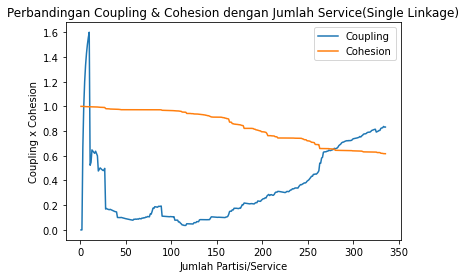

In [60]:
visualizeQualityCluster(qcSingle,"Single Linkage")

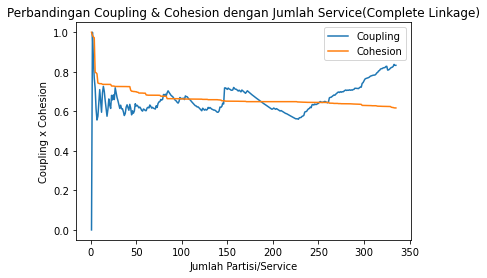

In [61]:
visualizeQualityCluster(qcComplete,"Complete Linkage")

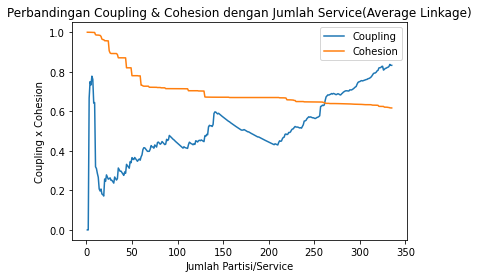

In [62]:
visualizeQualityCluster(qcAverage,"Average Linkage")

In [63]:
# tmpCount =  0
# for i in range(163,250):
#     # if qcAverage[i]['cohesion']-qcAverage[i]['coupling'] > 0.20:
#     print(detailStat(qcAverage,zAverage,targetSize=[qcAverage[i]['clusterSize']]))
#         # print(f"Coup: {qcAverage[i]['coupling']} , Coh {qcAverage[i]['cohesion']} , Size: {qcAverage[i]['clusterSize']}")
#     tmpCount +=1


#### Pemilihan Jumlah Cluster Terbaik

In [64]:
def pilihMaxVal(qc,label):
    maxVal = {'value':None , 'clusterSize' : len(listLabel)}
    for c in qc:
        if maxVal['value'] == None:
            maxVal = c
        if c['value'] >= maxVal['value']  :
            maxVal = c
    print(f'Linkage Method: {label} \nJumlah Cluster terbaik: {maxVal["clusterSize"]} service/partisi \nDetail:',  maxVal)

Pembagian service dengan modules-nya

In [65]:
def debugCluster(z,size):
    ct = cut_tree(z, n_clusters=size)
    clusterCT = cutTreeToCluster(ct)
    mgCls, inCls = mergeClass(ct)
    adjMerge, _ =  createAdjacentMatrix(mgCls)
    # print(clusterCT)
    return clusterCT
    
# debugCluster(zAverage,226)

### Gen Latex untuk Pelaporan 

In [66]:
# debugCluster(zAverage,200)

{0: ['addons.auth_totp_mail',
  'addons.base.wizard.base_partner_merge',
  'addons.base.models.ir_sequence',
  'addons.contacts',
  'addons.base.models.ir_asset'],
 1: ['addons.base.models.res_users',
  'addons.fleet',
  'addons.sales_team',
  'addons.iap',
  'addons.account_check_printing',
  'addons.base_vat',
  'addons.partner_autocomplete',
  'addons.snailmail_account',
  'addons.snailmail',
  'addons.membership'],
 2: ['addons.auth_signup', 'addons.portal'],
 3: ['addons.web'],
 4: ['addons.hr_work_entry_contract',
  'addons.resource',
  'addons.hr_work_entry',
  'addons.hr_holidays',
  'addons.hr_contract'],
 5: ['addons.base.models.ir_http', 'addons.google_recaptcha'],
 6: ['addons.base.models.res_config',
  'addons.digest',
  'addons.base_geolocalize',
  'addons.auth_ldap',
  'addons.auth_password_policy'],
 7: ['addons.base.models.res_partner',
  'addons.uom',
  'addons.base_sparse_field'],
 8: ['addons.website_sale_loyalty', 'addons.sale_loyalty'],
 9: ['addons.loyalty',
  'a

In [67]:
def statQC(qc):
    iterSum = 0
    stat = { "coupling" : {"min": 1, "max": 0 , "sum": 0} ,"cohesion" : {"min": 1, "max": 0 , "sum": 0 }  }
    for r in qc:
        if iterSum == 0:
            iterSum +=1
            continue
        
        if r['coupling'] < stat['coupling']['min'] and r['coupling'] != 0:
            stat['coupling']['min'] = r['coupling']
        if r['coupling'] > stat['coupling']['max']:
            stat['coupling']['max'] = r['coupling']
            
        if r['cohesion'] < stat['cohesion']['min']  and r['cohesion'] != 0:
            stat['cohesion']['min'] = r['cohesion']
        if r['cohesion'] > stat['cohesion']['max']:
            stat['cohesion']['max'] = r['cohesion']
        
        stat["coupling"]['sum'] += r['coupling']
        stat["cohesion"]['sum'] += r['cohesion']
        iterSum+=1
    return stat , iterSum

In [68]:
stat, iterSum = statQC(qcSingle)
print("Single")
print(stat)
print("AVG Coh: " ,stat['cohesion']['sum']/iterSum)
print("AVG Coup: " , stat['coupling']['sum']/iterSum)

Single
{'coupling': {'min': 0.036363, 'max': 1.6, 'sum': 115.19362299999999}, 'cohesion': {'min': 0.616957, 'max': 1.0, 'sum': 279.170608}}
AVG Coh:  0.8333450985074627
AVG Coup:  0.34386156119402983


In [69]:
stat, iterSum = statQC(qcComplete)
print("Complete")
print(stat)
print("AVG Coh: " ,stat['cohesion']['sum']/iterSum)
print("AVG Coup: " , stat['coupling']['sum']/iterSum)

Complete
{'coupling': {'min': 0.555948, 'max': 1.0, 'sum': 222.03552400000004}, 'cohesion': {'min': 0.616957, 'max': 0.984387, 'sum': 222.0503669999999}}
AVG Coh:  0.6628369164179102
AVG Coup:  0.662792608955224


In [70]:
stat, iterSum = statQC(qcAverage)
print("Average")
print(stat)
print("AVG Coh: " ,stat['cohesion']['sum']/iterSum)
print("AVG Coup: " , stat['coupling']['sum']/iterSum)

Average
{'coupling': {'min': 0.171387, 'max': 0.837311, 'sum': 172.82830999999996}, 'cohesion': {'min': 0.616957, 'max': 1.0, 'sum': 236.5714669999999}}
AVG Coh:  0.7061834835820893
AVG Coup:  0.5159054029850745


In [71]:
# Size	Service Size	Coupling	Cohesion	MIN Size	AVG Size	Max Size
def detailStat(qc,z, targetSize = [1, 2, 5, 10, 15, 25, 50 , 75, 90, 110, 130, 150, 175, 195, 200, 208 , 220, 232,  245, 275, 290, 305, 325, 335]):
    def humanReadableArr(arr):
        count_dict = {}
        for num in arr:
            if num not in count_dict:
                count_dict[num] = 1
            else:
                count_dict[num] += 1

        result = []
        for num, count in count_dict.items():
            result.append(f"{num}({count}x)")

        return ', '.join(result)
    results = []
    for _ , q in enumerate(qc):
        if q['clusterSize'] not in targetSize:
            continue
        minSize = len(qc)
        maxSize = 0
        sumSize = 0
        
        ct = cut_tree(z, n_clusters=q['clusterSize'])
        clusterCT = cutTreeToCluster(ct)  
        serviceSize = []
        
        for _ , m  in clusterCT.items():
            s = len(m)
            if s < minSize:
                minSize = s
            if s > maxSize:
                maxSize = s
            sumSize += s
            serviceSize.append(s)
        serviceSize.sort(reverse=True)
        # print(q)
        results.append({
            "size": q['clusterSize'],
            "coupling" : q['coupling'],
            "cohesion" : q['cohesion'],
            "service_size" : humanReadableArr(serviceSize),
            "min" : minSize,
            "max" : maxSize,
            "range" : maxSize-minSize,
        })
    return results
def toLatexUkuranService(data):
    colorGood = '\cellcolor{colorGood}'
    colorBad = '\cellcolor{colorBad}'
    colorOK = '\cellcolor{colorOK}'
    for x in data:
        coupColor = colorGood
        cohColor = colorGood
        if round(x['coupling'],2) > round(x['cohesion'],2):
            coupColor = colorBad
            cohColor = colorBad
        #Beda tipis (0.10)
        elif round(x['cohesion'],2) - round(x['coupling'],2) < 0.11 :
           coupColor = colorOK
           cohColor = colorOK    
        rangeColor = colorGood
        if round(x['range'],2)  > 12:
            rangeColor = colorBad
        print(f"{x['size']} & {x['service_size']} & {coupColor}  {round(x['coupling'],2)} & {cohColor} {round(x['cohesion'],2)} & {round(x['min'],2)} & {round(x['max'],2)} & {rangeColor} {round(x['range'],2)} \\\\   \hline")

In [122]:
toLatexUkuranService(detailStat(qcSingle,zSingle))

1 & 335(1x) & \cellcolor{colorGood}  0.0 & \cellcolor{colorGood} 1.0 & 335 & 335 & \cellcolor{colorGood} 0 \\   \hline
2 & 333(1x), 2(1x) & \cellcolor{colorGood}  0.0 & \cellcolor{colorGood} 1.0 & 2 & 333 & \cellcolor{colorBad} 331 \\   \hline
5 & 326(1x), 5(1x), 2(1x), 1(2x) & \cellcolor{colorBad}  1.2 & \cellcolor{colorBad} 1.0 & 1 & 326 & \cellcolor{colorBad} 325 \\   \hline
10 & 319(1x), 5(1x), 2(3x), 1(5x) & \cellcolor{colorBad}  1.6 & \cellcolor{colorBad} 1.0 & 1 & 319 & \cellcolor{colorBad} 318 \\   \hline
15 & 315(1x), 3(1x), 2(4x), 1(9x) & \cellcolor{colorGood}  0.63 & \cellcolor{colorGood} 1.0 & 1 & 315 & \cellcolor{colorBad} 314 \\   \hline
25 & 299(1x), 5(1x), 3(1x), 2(6x), 1(16x) & \cellcolor{colorGood}  0.48 & \cellcolor{colorGood} 0.99 & 1 & 299 & \cellcolor{colorBad} 298 \\   \hline
50 & 246(1x), 15(1x), 6(2x), 4(1x), 3(1x), 2(11x), 1(33x) & \cellcolor{colorGood}  0.09 & \cellcolor{colorGood} 0.97 & 1 & 246 & \cellcolor{colorBad} 245 \\   \hline
75 & 246(1x), 7(1x), 3(1

In [121]:
toLatexUkuranService(detailStat(qcComplete,zComplete))

1 & 335(1x) & \cellcolor{colorGood}  0.0 & \cellcolor{colorGood} 1.0 & 335 & 335 & \cellcolor{colorGood} 0 \\   \hline
2 & 324(1x), 11(1x) & \cellcolor{colorBad}  1.0 & \cellcolor{colorBad} 0.98 & 11 & 324 & \cellcolor{colorBad} 313 \\   \hline
5 & 212(1x), 88(1x), 17(1x), 11(1x), 7(1x) & \cellcolor{colorOK}  0.72 & \cellcolor{colorOK} 0.8 & 7 & 212 & \cellcolor{colorBad} 205 \\   \hline
10 & 132(1x), 88(1x), 31(1x), 17(2x), 16(1x), 11(1x), 8(2x), 7(1x) & \cellcolor{colorOK}  0.71 & \cellcolor{colorOK} 0.74 & 7 & 132 & \cellcolor{colorBad} 125 \\   \hline
15 & 107(1x), 88(1x), 31(1x), 17(2x), 16(1x), 11(1x), 10(1x), 8(2x), 7(2x), 4(1x), 2(2x) & \cellcolor{colorOK}  0.7 & \cellcolor{colorOK} 0.74 & 2 & 107 & \cellcolor{colorBad} 105 \\   \hline
25 & 88(1x), 46(1x), 31(1x), 17(2x), 16(2x), 11(1x), 10(2x), 8(4x), 7(2x), 5(1x), 4(3x), 2(5x) & \cellcolor{colorOK}  0.68 & \cellcolor{colorOK} 0.73 & 2 & 88 & \cellcolor{colorBad} 86 \\   \hline
50 & 67(1x), 25(1x), 17(2x), 16(1x), 15(1x), 10(2

In [120]:
toLatexUkuranService(detailStat(qcAverage,zAverage,targetSize=[x for x in range(1,336)]))

1 & 335(1x) & \cellcolor{colorGood}  0.0 & \cellcolor{colorGood} 1.0 & 335 & 335 & \cellcolor{colorGood} 0 \\   \hline
2 & 333(1x), 2(1x) & \cellcolor{colorGood}  0.0 & \cellcolor{colorGood} 1.0 & 2 & 333 & \cellcolor{colorBad} 331 \\   \hline
3 & 332(1x), 2(1x), 1(1x) & \cellcolor{colorGood}  0.67 & \cellcolor{colorGood} 1.0 & 1 & 332 & \cellcolor{colorBad} 331 \\   \hline
4 & 330(1x), 2(2x), 1(1x) & \cellcolor{colorGood}  0.75 & \cellcolor{colorGood} 1.0 & 1 & 330 & \cellcolor{colorBad} 329 \\   \hline
5 & 329(1x), 2(2x), 1(2x) & \cellcolor{colorGood}  0.73 & \cellcolor{colorGood} 1.0 & 1 & 329 & \cellcolor{colorBad} 328 \\   \hline
6 & 328(1x), 2(2x), 1(3x) & \cellcolor{colorGood}  0.78 & \cellcolor{colorGood} 1.0 & 1 & 328 & \cellcolor{colorBad} 327 \\   \hline
7 & 327(1x), 2(2x), 1(4x) & \cellcolor{colorGood}  0.76 & \cellcolor{colorGood} 1.0 & 1 & 327 & \cellcolor{colorBad} 326 \\   \hline
8 & 326(1x), 2(2x), 1(5x) & \cellcolor{colorGood}  0.64 & \cellcolor{colorGood} 1.0 & 1 & 3

In [123]:
def detailService(z, size):
    ct = cut_tree(z, n_clusters=size)
    clusterCT = cutTreeToCluster(ct) 
    # targetIdx = [0, 1, 2, 3, 4, 5, 6, 7 , 8 , 9, 12, 13 , 16, 19, 21, 31, 55, 56, 57 , 79, 100, 132, 158, 192, 199] 
    
    # print(len(targetIdx))
    for i , m  in clusterCT.items():
        # if i not in targetIdx:
        #     continue
        strRaw = ', '.join(m)
        cleanStr = strRaw.replace('_', '{\_}')
        cleanStr = cleanStr.replace("addons.", "")
        print(f"{1+i} & { cleanStr } \\\\ \hline")

In [125]:
# detailService(zAverage,200)

In [77]:
def traverseDictionary(data):
    if 'outsideCall' in data:
        return data
    else:
        for _ , value in data.items():
            if isinstance(value, dict):
                return traverseDictionary(value)
    return None

In [78]:
def getDetailModule(targetModules):
    relInfo = odooTree.getRelation(targetModules)
    relInfo = traverseDictionary(relInfo)

    result = {}
    for r in relInfo['relation']:
        memoRel = {}
        rDetail = odooTree.countCall(f"{targetModules}.{r}")
        for k, rdV in rDetail.items():
            kArrName = k.split(".")
            newKName = ".".join(kArrName[1:3])
            if newKName not in memoRel:
                memoRel[newKName] = 0
            #Untuk kasus pemanggilan fungsi di diri sendiri !
            if isinstance(rdV, dict):
                for k, inCall in rdV.items():
                    memoRel[newKName] += inCall        
                continue
            memoRel[newKName] += rdV
        result[r] = memoRel
        # print(f"{r} => " , memoRel)
    return result
        

In [79]:
targetModules = "addons.calendar.models"
getDetailModule(targetModules)

{'calendar_event': {'mail.models': 3, 'calendar.models': 43, 'base.models': 6},
 'calendar_alarm_manager': {'calendar.models': 4},
 'res_users': {'base.models': 1, 'calendar.models': 1},
 'res_partner': {'base.models': 1, 'calendar.models': 6},
 'calendar_recurrence': {'calendar.models': 28, 'base.models': 2},
 'calendar_attendee': {'base.models': 6, 'calendar.models': 3},
 'calendar_alarm': {'base.models': 2, 'mail.models': 1, 'calendar.models': 0},
 'calendar_event_type': {'base.models': 2, 'calendar.models': 0},
 'calendar_filter': {'base.models': 4, 'calendar.models': 0},
 'ir_http': {'base.models': 1, 'calendar.models': 0},
 'mail_activity': {'mail.models': 1, 'calendar.models': 1},
 'mail_activity_mixin': {'mail.models': 1, 'calendar.models': 1},
 'mail_activity_type': {'mail.models': 1, 'calendar.models': 0}}

In [80]:
def generateRowModelModule(moduleStr, targetModules):
    def dict_to_string(dictionary):
        pairs = []
        for key, value in dictionary.items():
            pairs.append(f"{key}: {value}")
        return ", ".join(pairs)
    result = getDetailModule(targetModules)
    iter = 0
    moduleStr = moduleStr.replace('_', '{\_}')
    row = "\\multirow{" + str(len(result)) + "}{*}{" + moduleStr + "}" 
    for moduleName, detailModels in result.items():
        relStr = dict_to_string(detailModels)
        relStr = relStr.replace('_', '{\_}')
        moduleName = moduleName.replace('_', '{\_}')
        if iter == 0:
            row += " &  "+  moduleName + " &  " +  relStr + " \\\\" 
            iter += 1
            continue
        row += " \\cline{2-3} " + " &  "+  moduleName + " &  " +  relStr 
        iter += 1
        row += " \\\\"
    print(row)
    print("--end")

In [81]:
# moduleName = "res.users"
# detailModels = [
#     {"user": "login : 1, abc : 2"},
#     {"admin": "sistem : 1"}
# ]

# latex_row = genLatexRow(moduleName,  detailModels)
# print(latex_row)


In [82]:
# generateRowModelModule("product.models","addons.product.models")

In [83]:
# generateRowModelModule("point_of_sale.models","addons.point_of_sale.models")

In [84]:
# generateRowModelModule("calendar.models","addons.calendar.models")

In [122]:
# targetModules = "addons.product.models"
# printDetailModule(targetModules)